# Parte 1: Análisis Exploratorio y Preprocesamiento

Este notebook contiene el análisis exploratorio de datos y el pipeline de preprocesamiento para el dataset de rayos X de tórax con neumonía.


In [7]:
# Importación de librerías
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from collections import Counter
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


## 1. Carga y Exploración de Datos


In [8]:
# Configuración de rutas
# Ajusta esta ruta según donde tengas el dataset descargado
DATA_DIR = Path('../data/chest_xray')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
VAL_DIR = DATA_DIR / 'val' if (DATA_DIR / 'val').exists() else None

# Verificar que el directorio existe
if not DATA_DIR.exists():
    print(f"⚠️  Advertencia: El directorio {DATA_DIR} no existe.")
    print("Por favor, descarga el dataset de Kaggle y colócalo en la carpeta 'data'")
    print("URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data")
else:
    print(f"✅ Directorio encontrado: {DATA_DIR}")


✅ Directorio encontrado: ../data/chest_xray


In [9]:
def load_image_paths(base_dir, class_name):
    """Carga las rutas de las imágenes de una clase específica"""
    class_dir = base_dir / class_name
    if class_dir.exists():
        image_paths = list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.jpg'))
        return image_paths
    return []

# Cargar rutas de imágenes
train_normal = load_image_paths(TRAIN_DIR, 'NORMAL')
train_pneumonia = load_image_paths(TRAIN_DIR, 'PNEUMONIA')
test_normal = load_image_paths(TEST_DIR, 'NORMAL')
test_pneumonia = load_image_paths(TEST_DIR, 'PNEUMONIA')

print(f"📊 Distribución de datos:")
print(f"  Train - Normal: {len(train_normal)}")
print(f"  Train - Pneumonia: {len(train_pneumonia)}")
print(f"  Test - Normal: {len(test_normal)}")
print(f"  Test - Pneumonia: {len(test_pneumonia)}")

# Crear DataFrame con información de las imágenes
def create_dataset_df(image_paths, split_name, class_label):
    """Crea un DataFrame con información de las imágenes"""
    data = []
    for img_path in image_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data.append({
                'path': str(img_path),
                'split': split_name,
                'class': class_label,
                'height': img.shape[0],
                'width': img.shape[1],
                'filename': img_path.name
            })
    return pd.DataFrame(data)

# Crear DataFrames
train_df = pd.concat([
    create_dataset_df(train_normal, 'train', 'NORMAL'),
    create_dataset_df(train_pneumonia, 'train', 'PNEUMONIA')
], ignore_index=True)

test_df = pd.concat([
    create_dataset_df(test_normal, 'test', 'NORMAL'),
    create_dataset_df(test_pneumonia, 'test', 'PNEUMONIA')
], ignore_index=True)

df = pd.concat([train_df, test_df], ignore_index=True)
print(f"\n✅ Dataset creado: {len(df)} imágenes totales")


📊 Distribución de datos:
  Train - Normal: 1341
  Train - Pneumonia: 3875
  Test - Normal: 234
  Test - Pneumonia: 390

✅ Dataset creado: 5840 imágenes totales


## 2. Visualización de Ejemplos


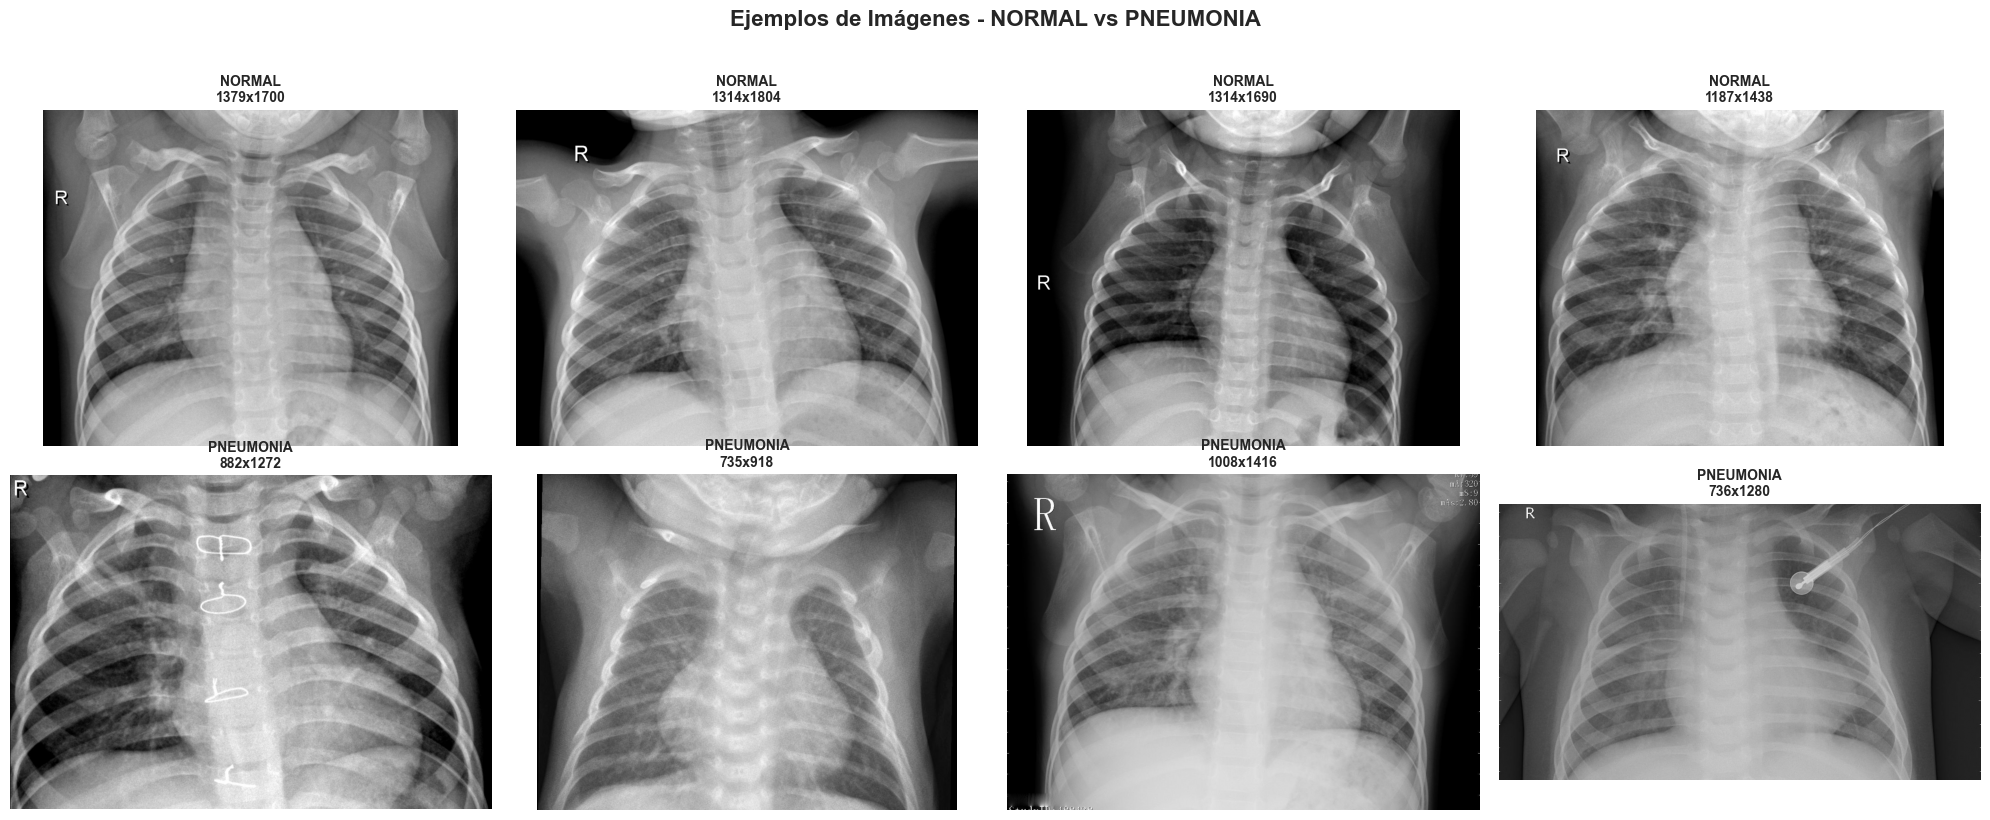

In [10]:
def visualize_samples(df, n_samples=8):
    """Visualiza muestras aleatorias de cada clase"""
    fig, axes = plt.subplots(2, n_samples//2, figsize=(20, 8))
    axes = axes.flatten()
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_samples = df[df['class'] == class_name].sample(n_samples//2)
        for idx, (_, row) in enumerate(class_samples.iterrows()):
            img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
            ax = axes[idx if class_name == 'NORMAL' else idx + n_samples//2]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"{class_name}\n{row['height']}x{row['width']}", 
                        fontsize=10, fontweight='bold')
            ax.axis('off')
    
    plt.suptitle('Ejemplos de Imágenes - NORMAL vs PNEUMONIA', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../results/ejemplos_imagenes.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(train_df)


## 3. Análisis de Distribución de Clases


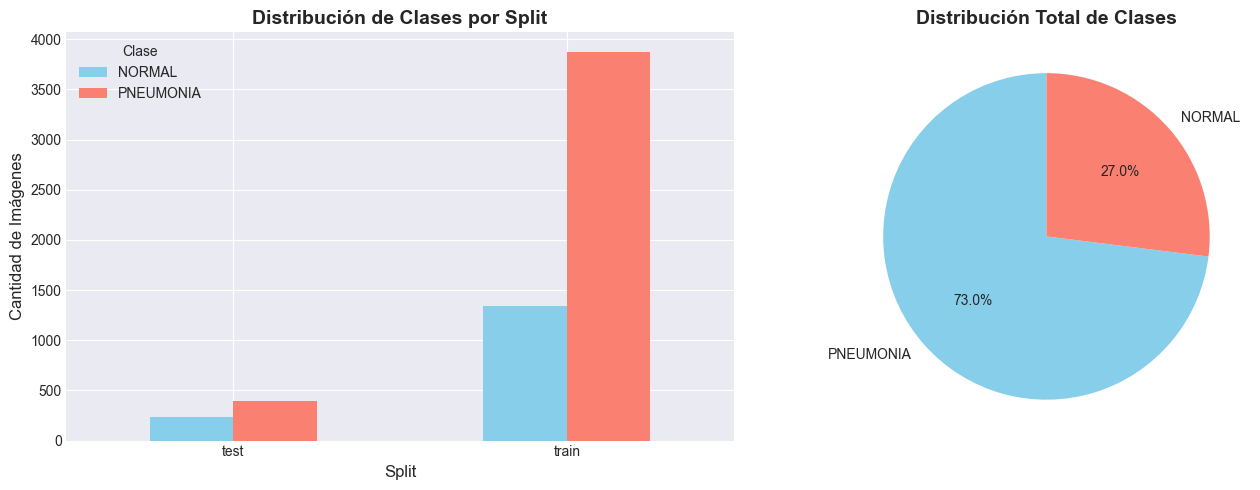


📊 Estadísticas de distribución:
class  NORMAL  PNEUMONIA
split                   
test      234        390
train    1341       3875

Total imágenes: 5840
Balance de clases: 26.97% NORMAL vs 73.03% PNEUMONIA


In [11]:
# Análisis de distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución por split
split_counts = df.groupby(['split', 'class']).size().unstack(fill_value=0)
split_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribución de Clases por Split', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Split', fontsize=12)
axes[0].set_ylabel('Cantidad de Imágenes', fontsize=12)
axes[0].legend(title='Clase')
axes[0].tick_params(axis='x', rotation=0)

# Distribución total
class_counts = df['class'].value_counts()
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
           colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Distribución Total de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/distribucion_clases.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Estadísticas de distribución:")
print(split_counts)
print(f"\nTotal imágenes: {len(df)}")
print(f"Balance de clases: {class_counts['NORMAL']/len(df)*100:.2f}% NORMAL vs {class_counts['PNEUMONIA']/len(df)*100:.2f}% PNEUMONIA")


## 4. Análisis de Tamaños de Imágenes


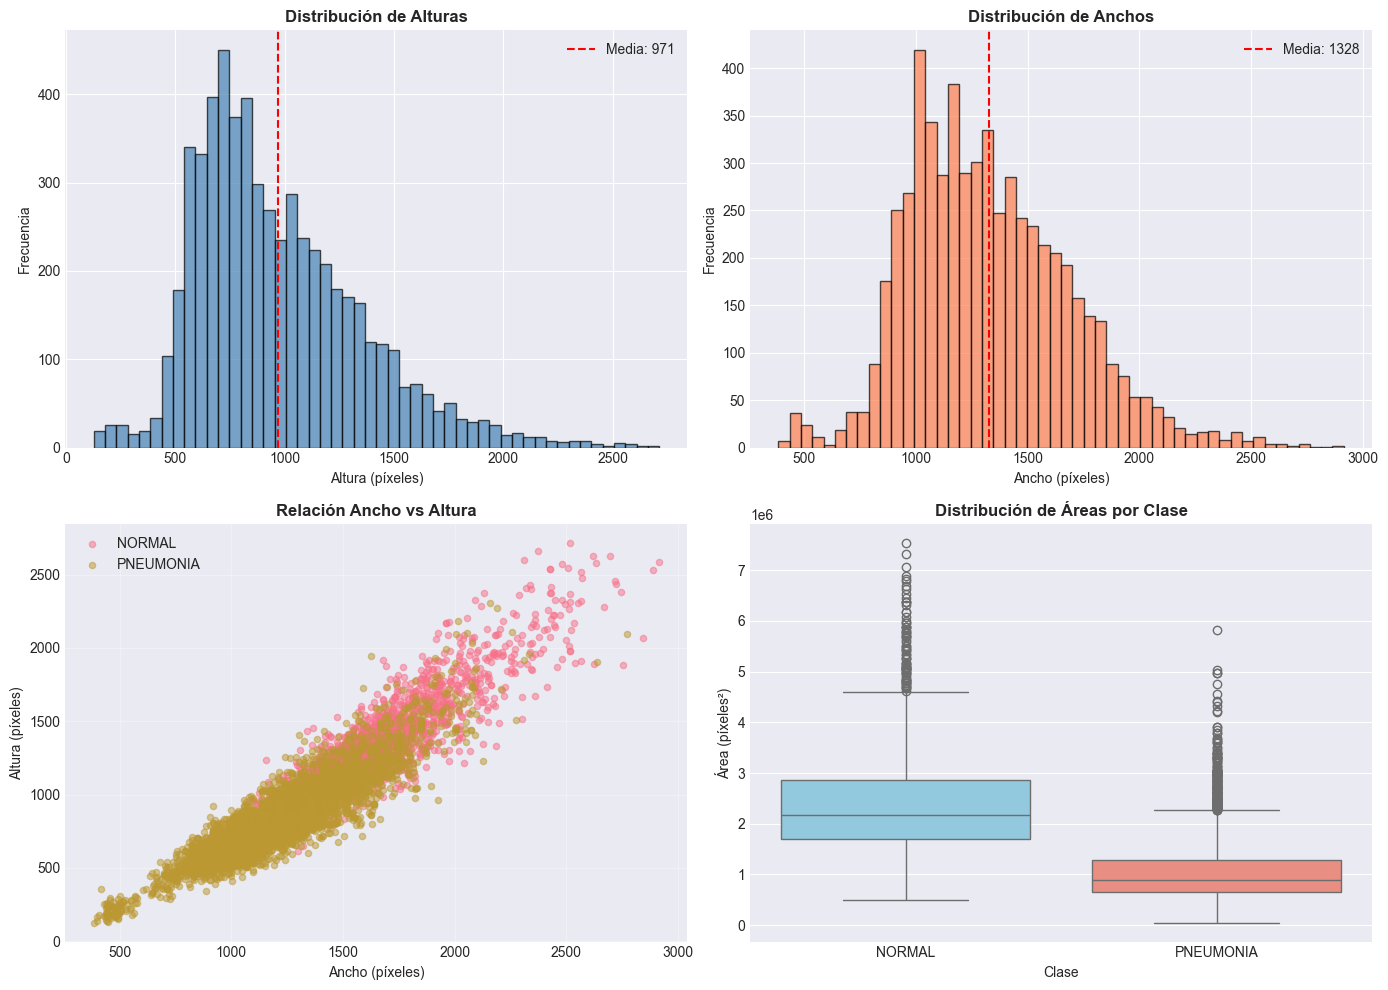


📏 Estadísticas de dimensiones:
            height        width          area
count  5840.000000  5840.000000  5.840000e+03
mean    970.600685  1327.825000  1.418933e+06
std     383.681911   363.764314  9.712773e+05
min     127.000000   384.000000  4.876800e+04
25%     688.000000  1056.000000  7.265280e+05
50%     886.000000  1281.000000  1.136704e+06
75%    1187.000000  1560.000000  1.851033e+06
max    2713.000000  2916.000000  7.532028e+06

Dimensiones únicas: 4793 combinaciones


In [12]:
# Análisis de dimensiones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma de alturas
axes[0, 0].hist(df['height'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Alturas', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Altura (píxeles)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(df['height'].mean(), color='red', linestyle='--', 
                   label=f'Media: {df["height"].mean():.0f}')
axes[0, 0].legend()

# Histograma de anchos
axes[0, 1].hist(df['width'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución de Anchos', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Ancho (píxeles)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].axvline(df['width'].mean(), color='red', linestyle='--',
                   label=f'Media: {df["width"].mean():.0f}')
axes[0, 1].legend()

# Scatter plot de dimensiones
for class_name in ['NORMAL', 'PNEUMONIA']:
    class_data = df[df['class'] == class_name]
    axes[1, 0].scatter(class_data['width'], class_data['height'], 
                      alpha=0.5, label=class_name, s=20)
axes[1, 0].set_title('Relación Ancho vs Altura', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Ancho (píxeles)')
axes[1, 0].set_ylabel('Altura (píxeles)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Boxplot de áreas
df['area'] = df['height'] * df['width']
sns.boxplot(data=df, x='class', y='area', ax=axes[1, 1], palette=['skyblue', 'salmon'])
axes[1, 1].set_title('Distribución de Áreas por Clase', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Clase')
axes[1, 1].set_ylabel('Área (píxeles²)')

plt.tight_layout()
plt.savefig('../results/analisis_dimensiones.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📏 Estadísticas de dimensiones:")
print(df[['height', 'width', 'area']].describe())
print(f"\nDimensiones únicas: {df.groupby(['height', 'width']).size().shape[0]} combinaciones")


## 5. Pipeline de Preprocesamiento

### 5.1 Normalización de Tamaño


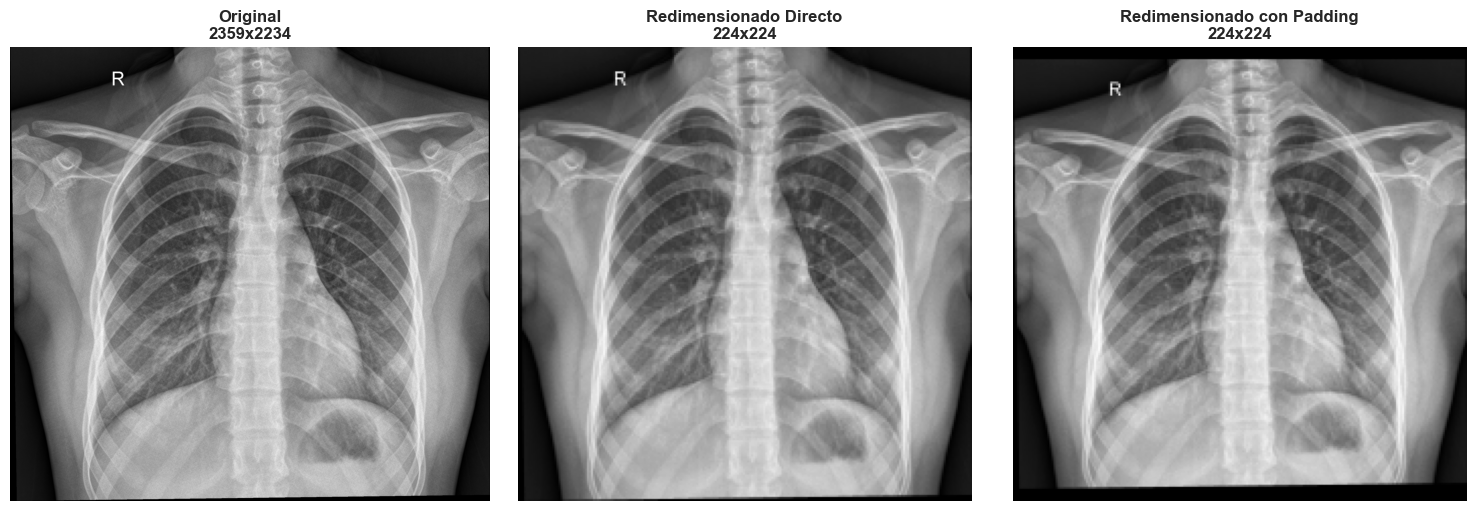

✅ Función de redimensionamiento implementada
   - Método 1: Redimensionamiento directo (puede distorsionar)
   - Método 2: Redimensionamiento con padding (mantiene relación de aspecto)


In [13]:
def resize_image(img, target_size=(224, 224), keep_aspect_ratio=False):
    """
    Redimensiona una imagen al tamaño objetivo.
    
    Args:
        img: Imagen de entrada (numpy array)
        target_size: Tamaño objetivo (ancho, alto)
        keep_aspect_ratio: Si True, mantiene la relación de aspecto y rellena con padding
    
    Returns:
        Imagen redimensionada
    """
    if keep_aspect_ratio:
        # Mantener relación de aspecto con padding
        h, w = img.shape[:2]
        target_w, target_h = target_size
        
        # Calcular escala
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)
        
        # Redimensionar
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Crear imagen con padding
        padded = np.zeros((target_h, target_w), dtype=img.dtype)
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        
        return padded
    else:
        # Redimensionamiento directo (puede distorsionar)
        return cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

# Probar diferentes métodos de redimensionamiento
sample_img_path = train_df.iloc[0]['path']
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title(f'Original\n{sample_img.shape[1]}x{sample_img.shape[0]}', 
                 fontsize=12, fontweight='bold')
axes[0].axis('off')

resized_direct = resize_image(sample_img, target_size=(224, 224), keep_aspect_ratio=False)
axes[1].imshow(resized_direct, cmap='gray')
axes[1].set_title(f'Redimensionado Directo\n224x224', fontsize=12, fontweight='bold')
axes[1].axis('off')

resized_padded = resize_image(sample_img, target_size=(224, 224), keep_aspect_ratio=True)
axes[2].imshow(resized_padded, cmap='gray')
axes[2].set_title(f'Redimensionado con Padding\n224x224', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('../results/comparacion_redimensionamiento.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Función de redimensionamiento implementada")
print("   - Método 1: Redimensionamiento directo (puede distorsionar)")
print("   - Método 2: Redimensionamiento con padding (mantiene relación de aspecto)")


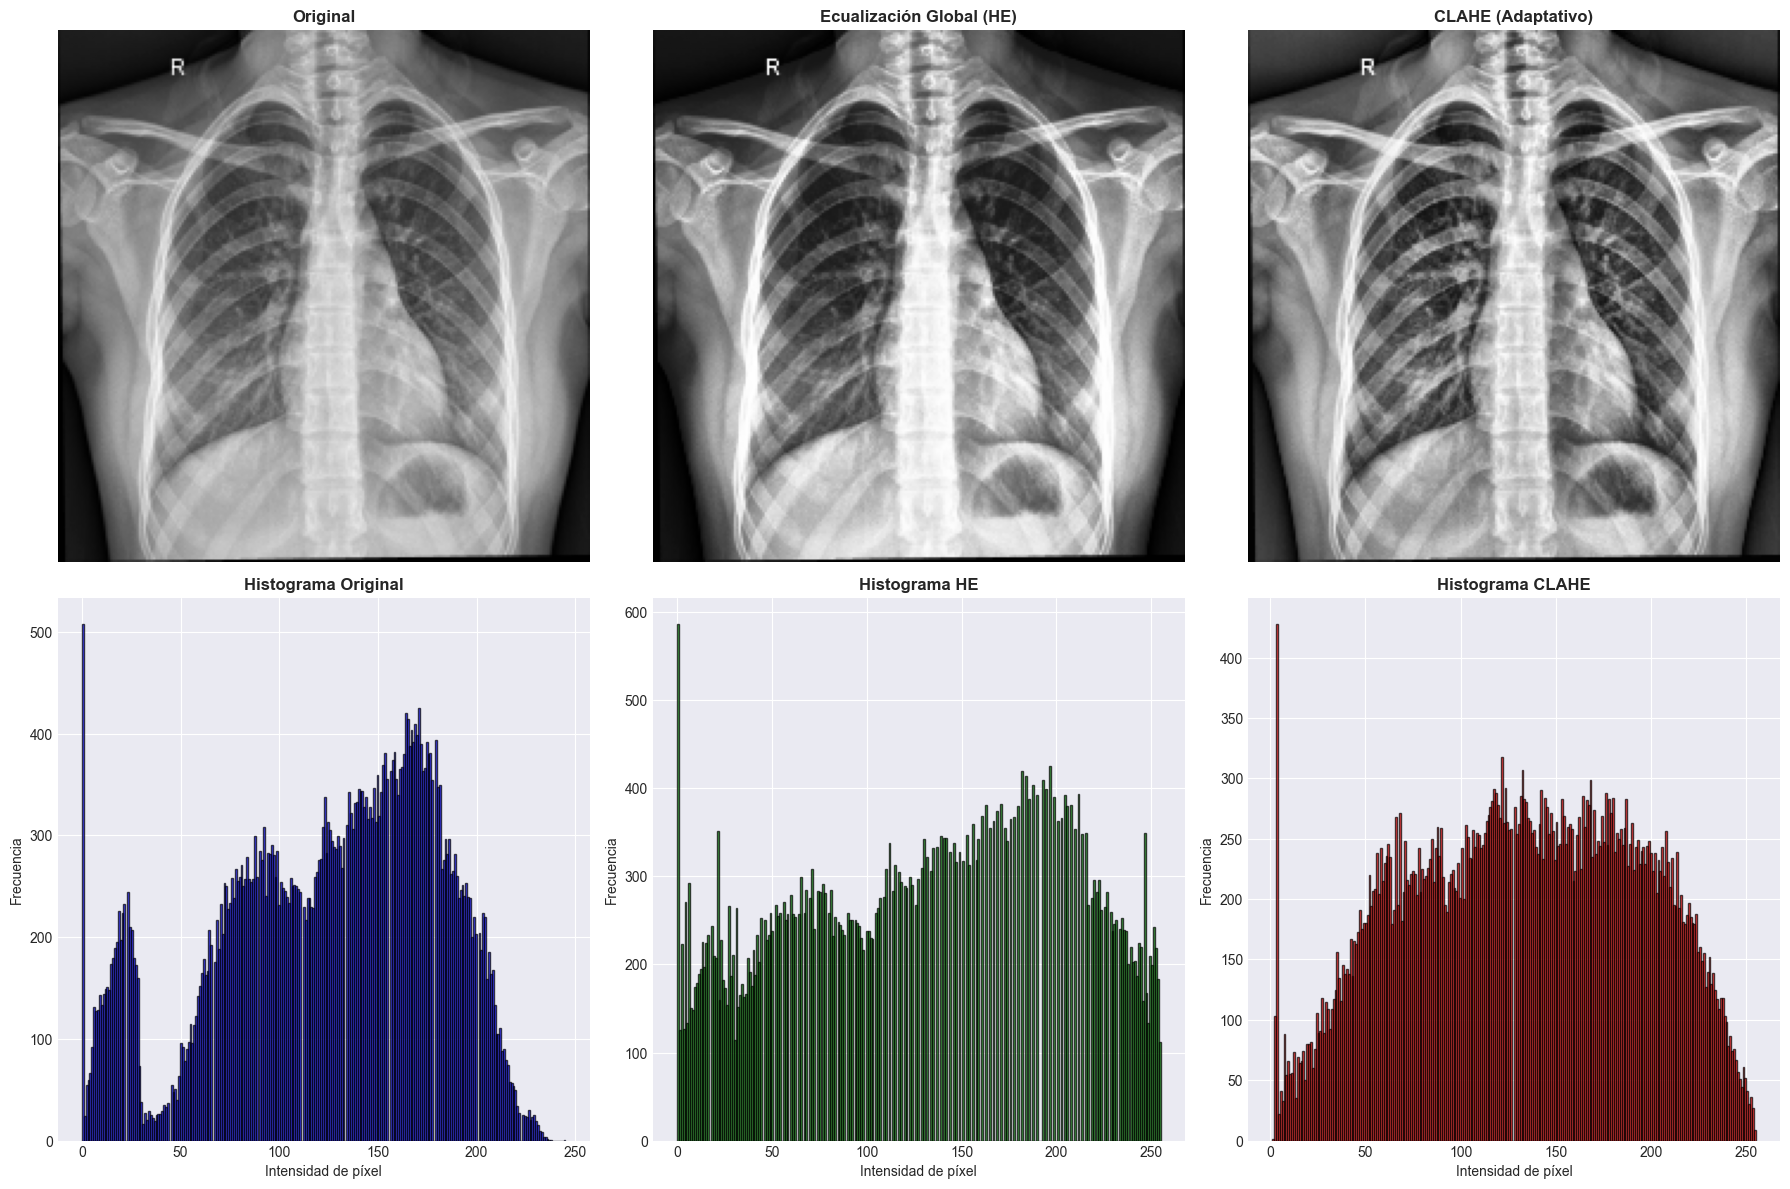

✅ Métodos de ecualización implementados:
   - Ecualización Global (HE): Mejora el contraste global
   - CLAHE: Mejora el contraste local, ideal para radiografías


In [14]:
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Aplica CLAHE (Contrast Limited Adaptive Histogram Equalization) a la imagen.
    CLAHE es especialmente útil para radiografías ya que mejora el contraste local
    sin amplificar demasiado el ruido.
    
    Args:
        img: Imagen de entrada (numpy array en escala de grises)
        clip_limit: Límite de contraste para evitar sobre-amplificación
        tile_grid_size: Tamaño de las ventanas para el procesamiento adaptativo
    
    Returns:
        Imagen ecualizada
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

def apply_histogram_equalization(img):
    """
    Aplica ecualización de histograma global (método tradicional).
    """
    return cv2.equalizeHist(img)

# Comparar diferentes métodos de ecualización
sample_img_resized = resize_image(sample_img, target_size=(224, 224))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Fila 1: Imágenes
axes[0, 0].imshow(sample_img_resized, cmap='gray')
axes[0, 0].set_title('Original', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

img_he = apply_histogram_equalization(sample_img_resized)
axes[0, 1].imshow(img_he, cmap='gray')
axes[0, 1].set_title('Ecualización Global (HE)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

img_clahe = apply_clahe(sample_img_resized)
axes[0, 2].imshow(img_clahe, cmap='gray')
axes[0, 2].set_title('CLAHE (Adaptativo)', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Fila 2: Histogramas
axes[1, 0].hist(sample_img_resized.flatten(), bins=256, color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Histograma Original', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Intensidad de píxel')
axes[1, 0].set_ylabel('Frecuencia')

axes[1, 1].hist(img_he.flatten(), bins=256, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Histograma HE', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Intensidad de píxel')
axes[1, 1].set_ylabel('Frecuencia')

axes[1, 2].hist(img_clahe.flatten(), bins=256, color='red', alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Histograma CLAHE', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Intensidad de píxel')
axes[1, 2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('../results/comparacion_ecualizacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Métodos de ecualización implementados:")
print("   - Ecualización Global (HE): Mejora el contraste global")
print("   - CLAHE: Mejora el contraste local, ideal para radiografías")


### 5.3 Pipeline Completo de Preprocesamiento


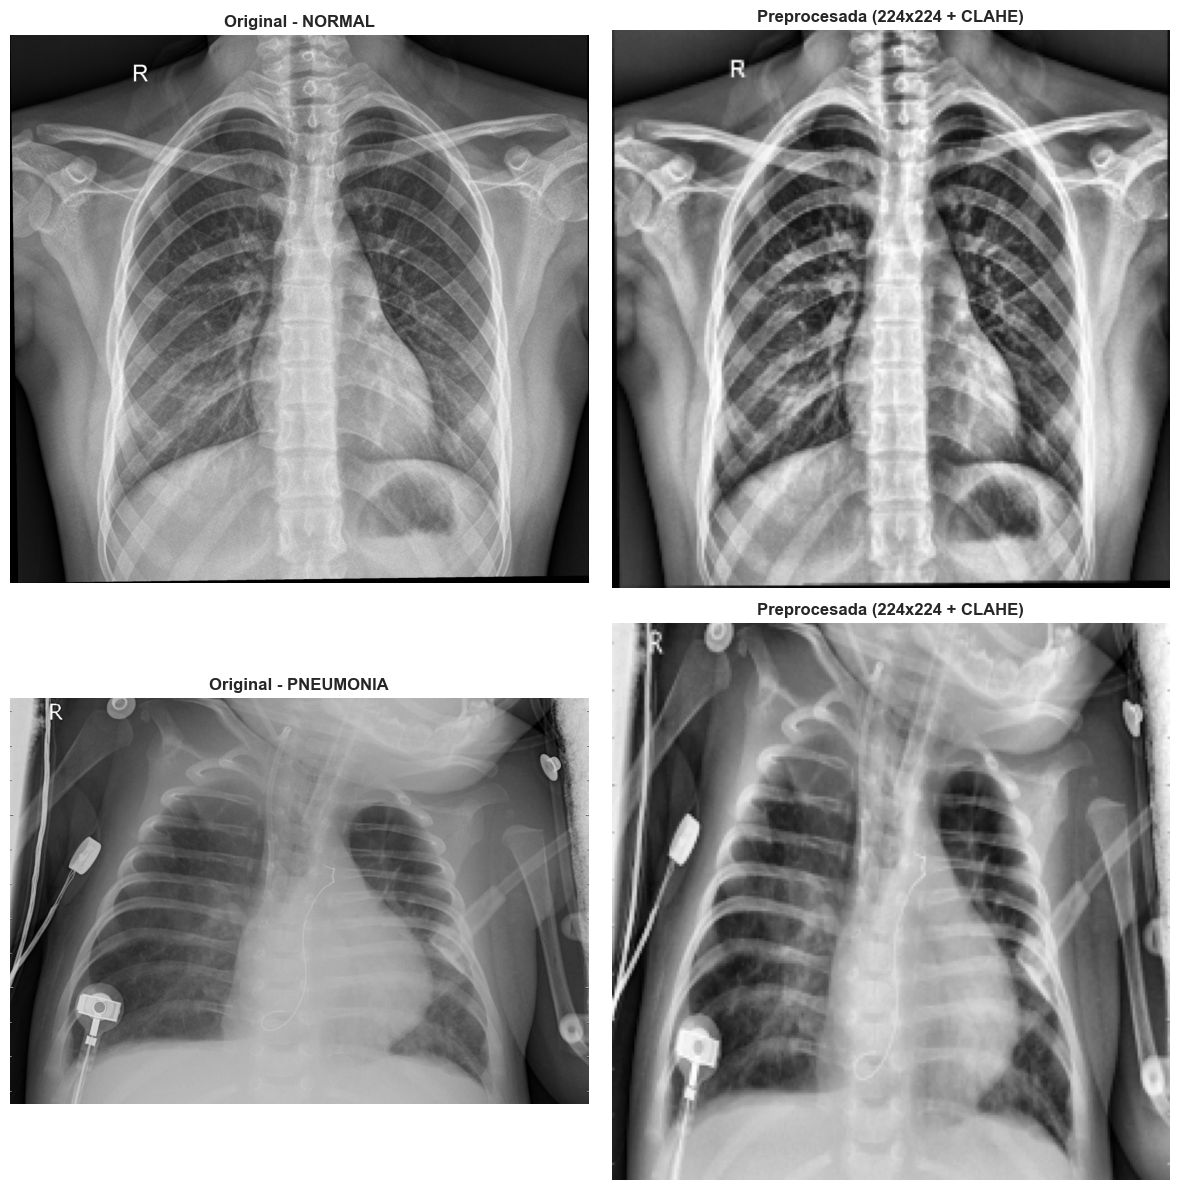

✅ Pipeline de preprocesamiento implementado y probado


In [15]:
def preprocess_image(img_path, target_size=(224, 224), apply_clahe_flag=True, 
                     normalize=True, keep_aspect_ratio=False):
    """
    Pipeline completo de preprocesamiento para una imagen.
    
    Args:
        img_path: Ruta a la imagen
        target_size: Tamaño objetivo para redimensionamiento
        apply_clahe_flag: Si True, aplica CLAHE
        normalize: Si True, normaliza los valores a [0, 1]
        keep_aspect_ratio: Si True, mantiene relación de aspecto
    
    Returns:
        Imagen preprocesada
    """
    # 1. Cargar imagen en escala de grises
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {img_path}")
    
    # 2. Redimensionar
    img = resize_image(img, target_size=target_size, keep_aspect_ratio=keep_aspect_ratio)
    
    # 3. Aplicar CLAHE (recomendado para radiografías)
    if apply_clahe_flag:
        img = apply_clahe(img)
    
    # 4. Normalizar a [0, 1]
    if normalize:
        img = img.astype(np.float32) / 255.0
    
    return img

# Probar el pipeline completo
sample_paths = [
    train_df[train_df['class'] == 'NORMAL'].iloc[0]['path'],
    train_df[train_df['class'] == 'PNEUMONIA'].iloc[0]['path']
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for idx, path in enumerate(sample_paths):
    # Original
    original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    axes[idx, 0].imshow(original, cmap='gray')
    axes[idx, 0].set_title(f'Original - {Path(path).parent.name}', 
                          fontsize=12, fontweight='bold')
    axes[idx, 0].axis('off')
    
    # Preprocesada
    preprocessed = preprocess_image(path, target_size=(224, 224), 
                                   apply_clahe_flag=True, normalize=False)
    axes[idx, 1].imshow(preprocessed, cmap='gray')
    axes[idx, 1].set_title('Preprocesada (224x224 + CLAHE)', 
                          fontsize=12, fontweight='bold')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.savefig('../results/pipeline_preprocesamiento.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Pipeline de preprocesamiento implementado y probado")


## 6. Guardar Datos Preprocesados (Opcional)

Guardamos las rutas y metadatos para uso en los siguientes notebooks.


In [16]:
# Guardar DataFrame con metadatos
df.to_csv('../data/metadata.csv', index=False)
print("✅ Metadatos guardados en '../data/metadata.csv'")

# Guardar estadísticas
stats = {
    'total_images': len(df),
    'train_images': len(train_df),
    'test_images': len(test_df),
    'normal_count': len(df[df['class'] == 'NORMAL']),
    'pneumonia_count': len(df[df['class'] == 'PNEUMONIA']),
    'mean_height': df['height'].mean(),
    'mean_width': df['width'].mean(),
    'std_height': df['height'].std(),
    'std_width': df['width'].std()
}

import json
with open('../data/statistics.json', 'w') as f:
    json.dump(stats, f, indent=2)

print("✅ Estadísticas guardadas en '../data/statistics.json'")
print("\n📋 Resumen:")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")


✅ Metadatos guardados en '../data/metadata.csv'
✅ Estadísticas guardadas en '../data/statistics.json'

📋 Resumen:
  total_images: 5840
  train_images: 5216
  test_images: 624
  normal_count: 1575
  pneumonia_count: 4265
  mean_height: 970.60
  mean_width: 1327.83
  std_height: 383.68
  std_width: 363.76


## 7. Justificación de Decisiones de Preprocesamiento

### Decisiones tomadas:

1. **Tamaño objetivo: 224x224 píxeles**
   - Tamaño estándar para modelos de deep learning
   - Balance entre resolución y eficiencia computacional
   - Permite usar modelos pre-entrenados

2. **CLAHE en lugar de ecualización global**
   - CLAHE mejora el contraste local sin amplificar ruido excesivamente
   - Específicamente diseñado para imágenes médicas
   - Parámetros: clip_limit=2.0, tile_grid_size=(8,8)

3. **Redimensionamiento directo vs. con padding**
   - Se implementaron ambos métodos para experimentación
   - El redimensionamiento directo es más rápido
   - El padding mantiene la relación de aspecto pero puede perder información

4. **Normalización a [0, 1]**
   - Facilita el entrenamiento de modelos
   - Evita problemas numéricos
   - Compatible con la mayoría de algoritmos de ML
